#Using Ablang heavy chain embeddings as predictors for hydrophobicity

A simple regression neural network is trained on Ablang heavy chain embeddings with heavy chain hydrophobicity as the target values.

In [1]:
#@title Mount drive and load libraries
import os, pandas as pd, numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
path = '/content/drive/MyDrive/msc-project-mbalmf01/msc-project-source-code-files-22-23-mbalmf01/notebooks'
os.chdir(path)

from ML_manipulation import standardise, normalise, regression_nn

In [ ]:
%%capture
!pip install git+https://github.com/huggingface/peft.git
!pip install loralib

In [ ]:
#@title Ablang finetuning using LoRa
from plm_manipulation import start_ablang
from peft import LoraConfig, get_peft_model
import torch
import pandas as pd

mapt = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/MAPT/230811_MAPT_scores_abs.csv')

sequences = mapt['Model Seq H'].to_numpy()
labels = mapt['Hydrophobic Surface H'].to_numpy()

model, tokenizer = start_ablang('AbLang_heavy')

config = LoraConfig(
    r=8, lora_alpha=32,
    lora_dropout=0.3,
    target_modules=['query', 'value']
)
for param in model.parameters():
    param.requires_grad = False  # freeze the model - train adapters later
    if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
        param.data = param.data.to(torch.float32)
model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()
model = get_peft_model(model, config)

model.print_trainable_parameters()
# trainable params: 294912 || all params: 85493760 || trainable%: 0.3449514911965505


In [44]:
mapt = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/MAPT/230811_MAPT_scores_abs.csv')
df = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230811_human_paired_seqs_MAPT.csv', dtype={'Run':np.str_})
tensor_df = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230811_human_paired_seqs_MAPT_ablang_heavy.csv')
tensor_df.head()


,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,seq_id
0,-0.460272,0.408849,-1.016937,-0.080830,0.026261,0.563961,0.857601,-0.225520,-0.398539,0.185614,...,0.363538,-0.235872,0.041527,0.002672,-0.102949,-0.081401,0.143393,0.643908,0.883769,AGTAGTCTCCAAATGC-1_contig_1_AGTAGTCTCCAAATGC-1...
1,-1.024419,0.227542,-0.361004,-0.357284,-0.364116,0.545933,0.433750,-0.274024,-0.284300,0.147625,...,0.495414,0.015551,0.280166,-0.619951,-0.226422,-0.302840,0.131804,0.326639,0.668544,AGTCTTTCAGATCCAT-1_contig_1_AGTCTTTCAGATCCAT-1...
2,-0.785821,0.335563,-0.393253,-0.407858,0.039940,1.169995,1.097658,-0.271673,-0.239737,0.302128,...,0.310388,-0.070901,0.398589,-0.685524,0.192048,-0.349333,-0.266015,0.616134,0.649999,AGTCTTTGTCCGCTGA-1_contig_2_AGTCTTTGTCCGCTGA-1...
3,-0.866275,0.475901,-0.758314,-0.743394,-0.255119,0.307467,0.748792,-0.201717,-0.477458,0.148124,...,-0.146728,-0.147275,-0.138680,-0.479482,0.421945,0.438290,-0.587603,0.358444,0.442684,AGTGAGGGTTACGCGC-1_contig_1_AGTGAGGGTTACGCGC-1...
4,-0.708096,0.032998,-0.747296,-0.223326,0.007777,0.722949,0.523601,-0.021252,-0.335064,0.071827,...,0.553346,-0.105938,0.301181,-0.443560,0.084466,-0.382639,0.047859,0.523858,0.460188,AGTGAGGTCCAACCAA-1_contig_1_AGTGAGGTCCAACCAA-1...


In [45]:
seqs = mapt['Model Seq H'].to_list()
mapt.rename(columns={'Model Seq H':'sequence_alignment_aa_heavy'}, inplace=True)
new = df.merge(how='left', right=mapt, on='sequence_alignment_aa_heavy')

new = new.drop_duplicates(subset='seq_id')

seq_ids = tensor_df['seq_id'].to_list()

new = new[new['seq_id'].isin(seq_ids)]
# Convert seq_id to categorical type and sort dataframe on that category
new['seq_id'] = pd.Categorical(new['seq_id'], categories=seq_ids, ordered=True)
new = new.sort_values('seq_id')
new.head()

,Unnamed: 1,sequence_id_heavy,ANARCI_status_heavy,sequence_heavy,sequence_alignment_aa_heavy,v_call_heavy,d_call_heavy,j_call_heavy,sequence_id_light,ANARCI_status_light,...,Charge pH7 L,Filename,Hydrophobic Surface Fv,Hydrophobic Surface H,Hydrophobic Surface L,MAPSS IgG1 pH5.0,MAPSS IgG1 pH7.4,MAPSS IgG4P pH5.0,MAPSS IgG4P pH7.4,Model Seq L
0,2696,AGTAGTCTCCAAATGC-1_contig_1,"|Deletions: 10, 73||||",ACTTTCTGAGAGTCCTGGACCTCCTGTGCAAGAACATGAAACATCT...,QVQLQESGPGLVKPSETLSLTCTVSGGSISSYYWSWIRQPPGKGLE...,IGHV4-59*01,IGHD1-1*01,IGHJ4*02,AGTAGTCTCCAAATGC-1_contig_2,|||||,...,-1.0,AGTAGTCTCCAAATGC-1_contig_1_1287185_chothia,509.81,285.72,224.09,2.077119,2.423306,2.336759,2.163666,QSVLTQPPSASGTPGQRVTISCSGSSSNIGSNTVNWYQQLPGTAPK...
1,2720,AGTCTTTCAGATCCAT-1_contig_1,"|Deletions: 10, 73||||",CGAGCCCAGCACTGGAAGTCGCCGGTGTTTCCATTCGGTGATCATC...,QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYAMHWVRQAPGKGLE...,IGHV3-30-3*01,IGHD3-16*02,IGHJ4*02,AGTCTTTCAGATCCAT-1_contig_2,|||||,...,-1.0,AGTCTTTCAGATCCAT-1_contig_1_1287185_chothia,512.93,295.59,217.34,1.378722,2.363523,2.166563,3.164672,QSALTQPASVSGSPGQSITISCTGTSSDVGGYNYVSWYQQHPGKAP...
2,2729,AGTCTTTGTCCGCTGA-1_contig_2,"|Deletions: 10, 73||||",GGGGAGCTCTGGGAGAGGAGCCCCAGCCCTGAGATTCCCAGGTGTT...,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,IGHV3-9*01,IGHD1-26*01,IGHJ4*02,AGTCTTTGTCCGCTGA-1_contig_1,|||||,...,-1.0,AGTCTTTGTCCGCTGA-1_contig_2_1287185_chothia,680.22,426.47,253.75,4.286981,5.845883,5.066432,4.263217,QSVLTQPPSASGTPGQRVTISCSGSSSNIGSNTVNWYQQLPGTAPK...
3,2760,AGTGAGGGTTACGCGC-1_contig_1,"|Deletions: 10, 73||||",GGGGAGTGACTCCTGTGCCCCACCATGGACACACTTTGCTCCACGC...,QITLKESGPTLVKPTQTLTLTCTFSGFSLSTSGVGVGWIRQPPGKA...,IGHV2-5*02,IGHD2-15*01,IGHJ5*02,AGTGAGGGTTACGCGC-1_contig_2,|||||,...,0.0,AGTGAGGGTTACGCGC-1_contig_1_1287185_chothia,460.64,214.97,245.67,1.265040,1.827280,1.686720,2.005992,QSALTQPASVSGSPGQSITISCTGSSSDVGSYNFVSWYQQHPGKAP...
4,2765,AGTGAGGTCCAACCAA-1_contig_1,"|Deletions: 10, 73||||",AGCTCTGAGAGAGGAGCCTTAGCCCTGGATTCCAAGGCCTATCCAC...,EVQLVESGGGLVKPGGSLRLSCAASGFTFSSYSMNWVRQAPGKGLE...,IGHV3-21*01,IGHD3-10*01,IGHJ4*02,AGTGAGGTCCAACCAA-1_contig_2,|||||,...,1.0,AGTGAGGTCCAACCAA-1_contig_1_1287185_chothia,739.06,496.91,242.15,3.852752,5.137002,5.137002,6.843848,QSALTQPASVSGSPGQSITISCTGTSSDVGSYNLVSWYQQHPGKAP...


In [46]:
new.to_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230813_human_paired_seqs_MAPT_scores.csv')

In [12]:
new.columns

Index(['Unnamed: 1', 'sequence_id_heavy', 'ANARCI_status_heavy',
       'sequence_heavy', 'sequence_alignment_aa_heavy', 'v_call_heavy',
       'd_call_heavy', 'j_call_heavy', 'sequence_id_light',
       'ANARCI_status_light', 'sequence_light', 'v_call_light', 'j_call_light',
       'sequence_alignment_aa_light', 'Run', 'seq_id', 'scfv', 'Acidics Fv',
       'Basics Fv', 'Charge pH5 Fv', 'Charge pH5 H', 'Charge pH5 L',
       'Charge pH7 Fv', 'Charge pH7 H', 'Charge pH7 L', 'Filename',
       'Hydrophobic Surface Fv', 'Hydrophobic Surface H',
       'Hydrophobic Surface L', 'MAPSS IgG1 pH5.0', 'MAPSS IgG1 pH7.4',
       'MAPSS IgG4P pH5.0', 'MAPSS IgG4P pH7.4', 'Model Seq L'],
      dtype='object')

In [35]:
#@title Split embeddings into training, validation and testing sets
embeddings = tensor_df.iloc[:,:-1]

#extract hydrophobic surfacce values as labels and normalise/standardise for regression
labels = new['Hydrophobic Surface H'].to_numpy()
labels, min_val, max_val = normalise(labels)
labels, mean_val, std_val = standardise(labels)

X_train = embeddings.iloc[:45000, :]
y_train = labels[:45000]

X_val = embeddings.iloc[45000:, :]
y_val = labels[45000:]

model = regression_nn(input_dim=embeddings.shape[1])

In [39]:
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
563/563 [==============================] - 7s 9ms/step - loss: 0.2937 - mean_absolute_error: 0.4207 - val_loss: 0.2002 - val_mean_absolute_error: 0.3467
Epoch 2/20
563/563 [==============================] - 5s 8ms/step - loss: 0.2132 - mean_absolute_error: 0.3605 - val_loss: 0.1792 - val_mean_absolute_error: 0.3253
Epoch 3/20
563/563 [==============================] - 7s 12ms/step - loss: 0.1944 - mean_absolute_error: 0.3438 - val_loss: 0.1685 - val_mean_absolute_error: 0.3193
Epoch 4/20
563/563 [==============================] - 5s 8ms/step - loss: 0.1827 - mean_absolute_error: 0.3330 - val_loss: 0.1817 - val_mean_absolute_error: 0.3256
Epoch 5/20
563/563 [==============================] - 5s 9ms/step - loss: 0.1778 - mean_absolute_error: 0.3279 - val_loss: 0.1737 - val_mean_absolute_error: 0.3233
Epoch 6/20
563/563 [==============================] - 7s 12ms/step - loss: 0.1700 - mean_absolute_error: 0.3201 - val_loss: 0.1656 - val_mean_absolute_error: 0.3144
Epoch 7/20
563

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               196864    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 238,081
Trainable params: 238,081
Non-tr

In [41]:
#@title Derive R^2 score
y_pred = model.predict(X_val)
y_pred = np.array([float(i) for i in y_pred])
r2 = r2_score(y_val, y_pred)
print(f'R^2 Score: {r2}')

425/425 [==============================] - 1s 3ms/step
R^2 Score: 0.8303232678468635


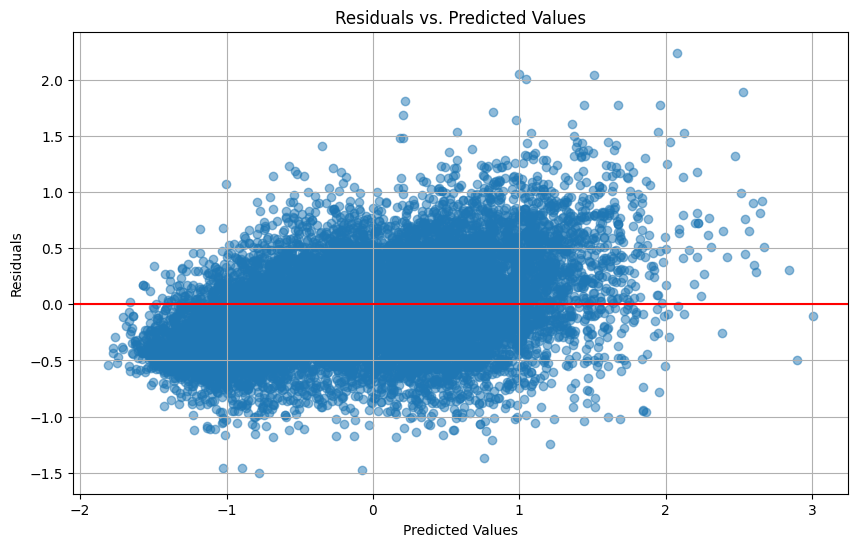

In [42]:
#@title Plot residuals vs predicted values
residuals = y_val - y_pred
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.show()

In [47]:
model.save('heavy_hydrophobicity_pred.h5')

In [ ]:
from google.colab import runtime

def disconnect_and_delete_runtime():
  """Disconnects and deletes the current runtime."""
  runtime.unassign()

disconnect_and_delete_runtime()